In [ ]:
# !sudo apt-get install -y fonts-nanum* | tail -n 1
# !sudo fc-cache -fv
# !rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no suc

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torchvision import models
from torchvision.io import read_image
import torchvision.transforms.functional as F

import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname = path, size = 10).get_name()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
font_name

'NanumGothic'

# Mask RCNN (Semantic segmentation)

In [ ]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs : list):
  if not isinstance(imgs, list):
    imgs = [imgs]

  fig, axs = plt.subplots(nrows=1, ncols=len(imgs), figsize = (10, 4), squeeze=False)

  for i, img in enumerate(imgs):
    img = F.to_pil_image(img) # tensor -> pil
    axs[0, i].imshow(img)
    axs[0, i].axis("off")

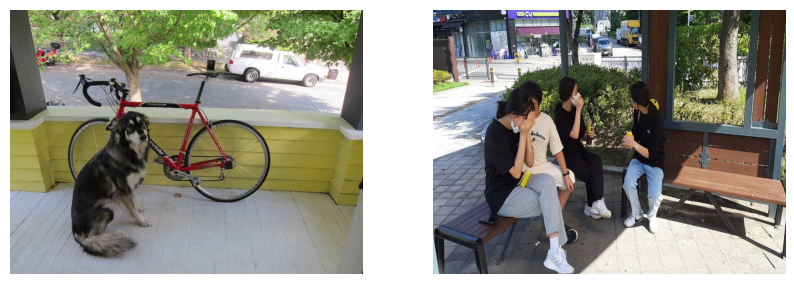

In [ ]:
img1 = read_image("/content/figure/dog.jpg")
img2 = read_image("/content/figure/peoples.jpg")

img_list = [img1, img2]

show(img_list)

## Bounding box 그리기

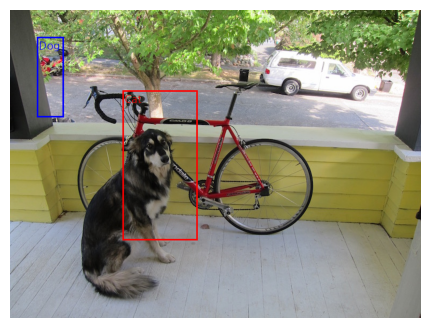

In [ ]:
from torchvision.utils import draw_bounding_boxes # torch

pred_boxes = torch.tensor([[50, 50, 100, 200],
                           [210, 150, 350, 430]], dtype = torch.float32) # (x_min, y_,min, x_max, y_max)

labels = ["Dog", "Cat"]
colors = ["blue", "red"]

result = draw_bounding_boxes(img1, pred_boxes, labels, colors, width = 3,
                             font = font_name, font_size = 20)
# result.shape
show(result)

## Mask RCNN model import

In [ ]:
dir(models.segmentation)

weights = models.segmentation.FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = models.segmentation.fcn_resnet50(weights = weights).to(device)

In [ ]:
img_list[0].shape
img_list[1].shape

weights.meta["categories"]


['__background__',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [ ]:
transforms = weights.transforms(resize_size=None)

batch = torch.stack([transforms(d) for d in img_list]).to(device)
# batch.shape

## 모델 추론

In [ ]:
import time
model.eval()

start = time.time()
output = model(batch) #
stop = time.time()

print(f"estimation time = {(stop - start)*1000:.3f}ms")

estimation time = 23.982ms


In [ ]:
output["out"].shape

torch.Size([2, 21, 576, 768])

## Class dictionary

In [ ]:
sem_class_to_idx = {cls:idx for idx, cls in enumerate(weights.meta["categories"])}
sem_class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

## Class score map

In [ ]:
output = output["out"]

# output.shape/
normalized_masks = torch.softmax(output, dim = 1)
normalized_masks.shape # 0 ~ 1 d

torch.Size([2, 21, 576, 768])

In [ ]:
img1_output = [normalized_masks[0, sem_class_to_idx[cls]] for cls in ["dog", "person"]]
img2_output = [normalized_masks[1, sem_class_to_idx[cls]] for cls in ["dog", "person"]]

dog_and_person_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(img_list))
      for cls in ("dog", "person")
]

for cls in ("dog", "person"):
  print(sem_class_to_idx[cls])

12
15


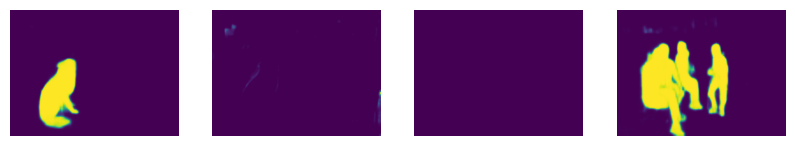

In [ ]:
show(dog_and_person_masks)
# show(img1_output)
# show(img2_output)


In [ ]:
# boolean_masks
print(normalized_masks.shape)

torch.Size([2, 21, 576, 768])


In [ ]:
boolean_masks = (normalized_masks.argmax(dim = 1) == sem_class_to_idx["person"]) | \
(normalized_masks.argmax(dim = 1) == sem_class_to_idx["dog"])

boolean_masks.shape

torch.Size([2, 576, 768])

shape = torch.Size([2, 576, 768]), dtype = torch.bool


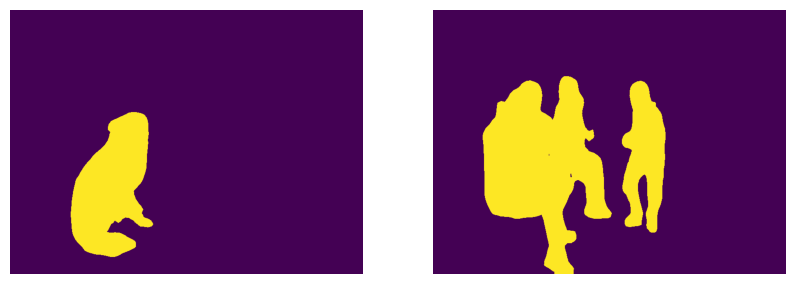

In [ ]:
print(f"shape = {boolean_masks.shape}, dtype = {boolean_masks.dtype}")
bool_list = [m.float() for m in boolean_masks]
show(bool_list)

## Overlay mask

In [ ]:
boolean_masks.shape

torch.Size([2, 576, 768])

In [ ]:
print(img_list[0].shape)
print(boolean_masks.shape)

torch.Size([3, 576, 768])
torch.Size([2, 576, 768])


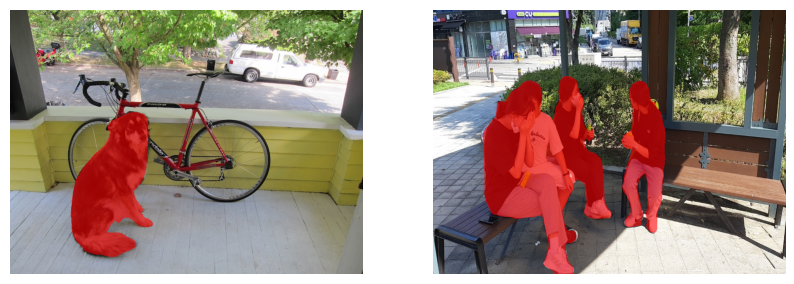

In [ ]:
from torchvision.utils import draw_segmentation_masks

# draw_img1 = draw_segmentation_masks(img2, masks = boolean_masks[1], colors = "red", alpha = 0.5)
# show(draw_img1)

dogs_person_masks = [
    draw_segmentation_masks(img, masks = mask, colors = "red", alpha = 0.6)
    for img, mask in zip(img_list, boolean_masks)
]

show(dogs_person_masks)